# Random Forest Classifier

The goal of this notebook is to classify our samples using a RandomForest model. We will attempt 3 different variations in terms of target variables.

1. Each individual accent
2. Consolidated accents (North, Mid, South, West)
3. Further consolidated regions (East, west)


We need to identify the optimal 

In [1]:
import librosa
import os
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, pairwise_distances, confusion_matrix

from matplotlib.colors import ListedColormap


from sklearn.ensemble import RandomForestClassifier

In [2]:
def plot_conf_matconf(conf_mat, save_fig=None):
    fig = plt.figure(figsize=(16, 14))
    ax= plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g');

    ax.set_xlabel('Predicted', fontsize=20)
    ax.xaxis.set_label_position('bottom')
    plt.xticks(rotation=90)
    ax.xaxis.tick_bottom()

    ax.set_ylabel('True', fontsize=20)
    plt.yticks(rotation=0)

    plt.title('Refined Confusion Matrix', fontsize=20)

    if save_fig:
        plt.savefig(f'{save_fig}.png')

    plt.show()

In [3]:
def average_speakers(mfcc_df):
    feature_cols = [x for x in mfcc_df.columns if 'feature' in x]
    
    target = mfcc_df[['speaker', 'accent']].drop_duplicates()
    
    mfcc_grouped = mfcc_df.groupby(['speaker', 'word'])[feature_cols].mean().reset_index()
    
    joined = pd.merge(how='left', left=mfcc_grouped, right = target, left_on='speaker', right_on = 'speaker')
    
    return joined



def load_data():
    train = pd.read_csv('all_words_train_mfcc.csv')
    test = pd.read_csv('all_words_test_mfcc.csv')
    
    train = train.loc[train['accent'] != 'DR8']
    test = test.loc[test['accent'] != 'DR8']
    test = test.loc[test.word.isin(train.word)].reset_index()
    
    train = average_speakers(train)
    
    british_df = pd.read_csv('british_mfcc.csv')
    feature_cols = [x for x in british_df.columns if 'feature' in x]
    
    return train, test, british_df[feature_cols]


train, test, british_df = load_data()

In [8]:
def fit_rf(train, test, word=None, features = None, k = None, display_conf = False):
    if features:
        feature_cols = features
        
    else:
        feature_cols = [x for x in train.columns if 'feature' in x]

    if word:
        train = train.loc[train['word'] == word]
        test = test.loc[test['word'] == word]
        
        
    X_train = train[feature_cols]
    y_train = train['accent']
    
    X_test = test[feature_cols]
    y_test = test['accent']
    
    
    tree_counts = []
    tree_count_score = []
    
    if k is None:
        fig, ax = plt.subplots(figsize=(20,10))

        for i in np.arange(1, 150, 1):
            tree_counts.append(i)
            clf = RandomForestClassifier(n_estimators = i, class_weight='balanced').fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            tree_count_score.append(1 - np.mean(y_pred == y_test))
            
        opt_score_idx = np.where(tree_count_score == np.amin(tree_count_score))
        opt_tree = tree_counts[opt_score_idx[0][0]]

        sns.lineplot(x=tree_counts, y=tree_count_score, ax=ax, markers=True)

        return tree_counts, tree_count_score, opt_score_idx, opt_tree
    
    clf = RandomForestClassifier(n_estimators = k, class_weight='balanced').fit(X_train, y_train)
    y_pred = clf.predict(X_test)  
    conf_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    
    conf_mat = confusion_matrix(y_test, y_pred)
    
    acc = np.mean(y_pred == y_test)
    
    if display_conf:
        plot_conf_matconf(conf_mat)
        print(f"Random Forest mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
        print(conf_df)
    
    return conf_df, clf

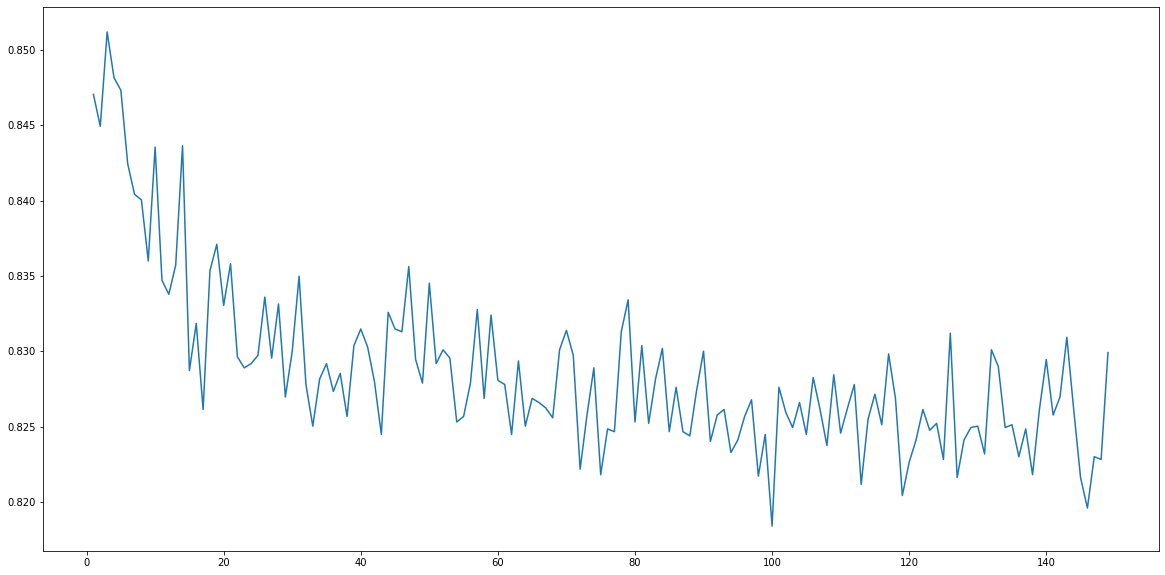

In [5]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(train, test)

In [9]:
print(f"The optimal tree count is: {opt_tree}")

The optimal tree count is: 100


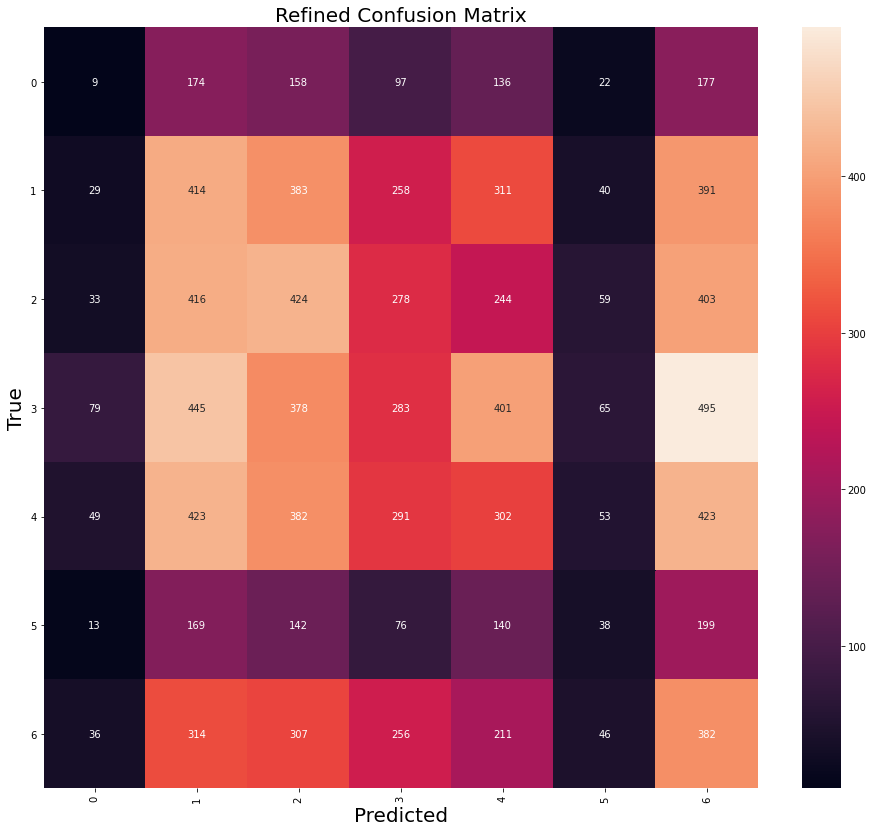

Random Forest mislabeled points out of a total 10854 points : 9002
                  DR1          DR2          DR3          DR4          DR5  \
precision    0.036290     0.175796     0.195032     0.183886     0.173066   
recall       0.011643     0.226725     0.228325     0.131873     0.157046   
f1-score     0.017630     0.198039     0.210370     0.153596     0.164667   
support    773.000000  1826.000000  1857.000000  2146.000000  1923.000000   

                  DR6          DR7  accuracy     macro avg  weighted avg  
precision    0.117647     0.154656  0.170628      0.148053      0.163082  
recall       0.048906     0.246134  0.170628      0.150093      0.170628  
f1-score     0.069091     0.189955  0.170628      0.143335      0.162214  
support    777.000000  1552.000000  0.170628  10854.000000  10854.000000  


In [10]:
rf_conf, rfw_clf = fit_rf(train, test, k=100, display_conf=True)

In [11]:
british_pred = rfw_clf.predict(british_df)

whole_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])
whole_pred['pred_tally'] = 1

print(whole_pred['pred_accent'].value_counts())


whole_bp = whole_pred.groupby('pred_accent').sum()
whole_bp['pred_percent'] = whole_bp['pred_tally'] / whole_bp['pred_tally'].sum() * 100.00

whole_bp.head(10)

DR7    448
DR2     91
DR3     72
DR4     69
DR5     33
DR6     17
DR1      2
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
DR1,2,0.273224
DR2,91,12.431694
DR3,72,9.836066
DR4,69,9.426230
DR5,33,4.508197
DR6,17,2.322404
DR7,448,61.202186


In [12]:
consolidate_region_map = {
    'DR1': 'North',
    'DR2': 'North',
    'DR3': 'Mid',
    'DR4': 'Mid',
    'DR5': 'South',
    'DR6': 'North',
    'DR7': 'West',
}



def consolidate_regions(train, test, dict_map):
    condensed_train = train.copy()
    condensed_train['region'] = condensed_train['accent'].map(dict_map)
    condensed_train['accent'] = condensed_train['region']
    
    condensed_test = test.copy()
    condensed_test['region'] = condensed_test['accent'].map(dict_map)
    condensed_test['accent'] = condensed_test['region']
    
    return condensed_train, condensed_test

In [13]:
condensed_train, condensed_test = consolidate_regions(train, test, consolidate_region_map)

condensed_test.accent.value_counts()

Mid      4003
North    3376
South    1923
West     1552
Name: accent, dtype: int64

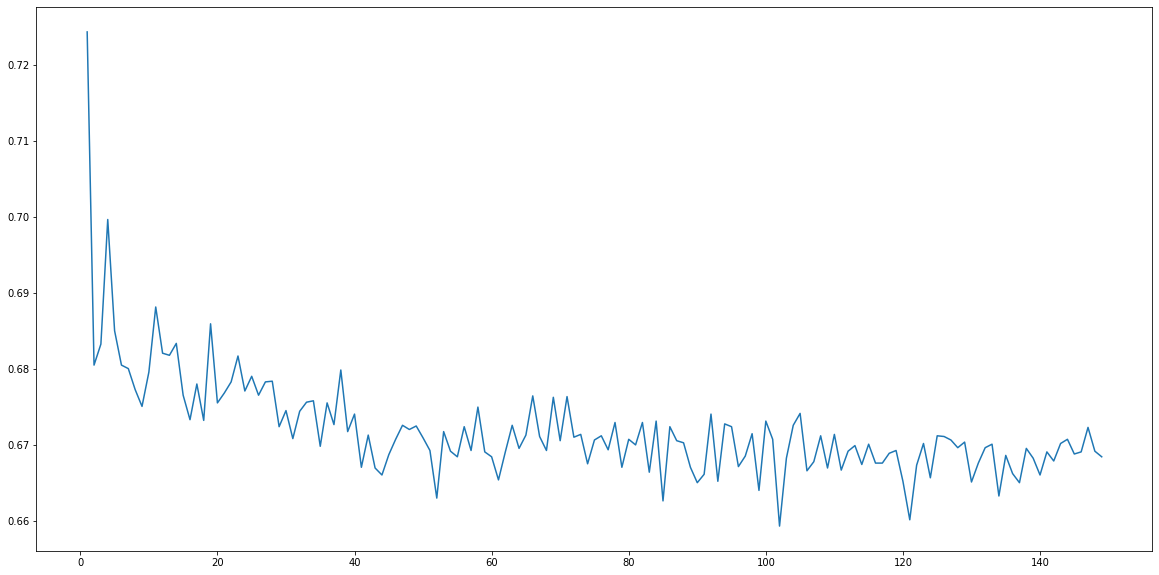

In [14]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(condensed_train, condensed_test)

In [15]:
opt_tree

102

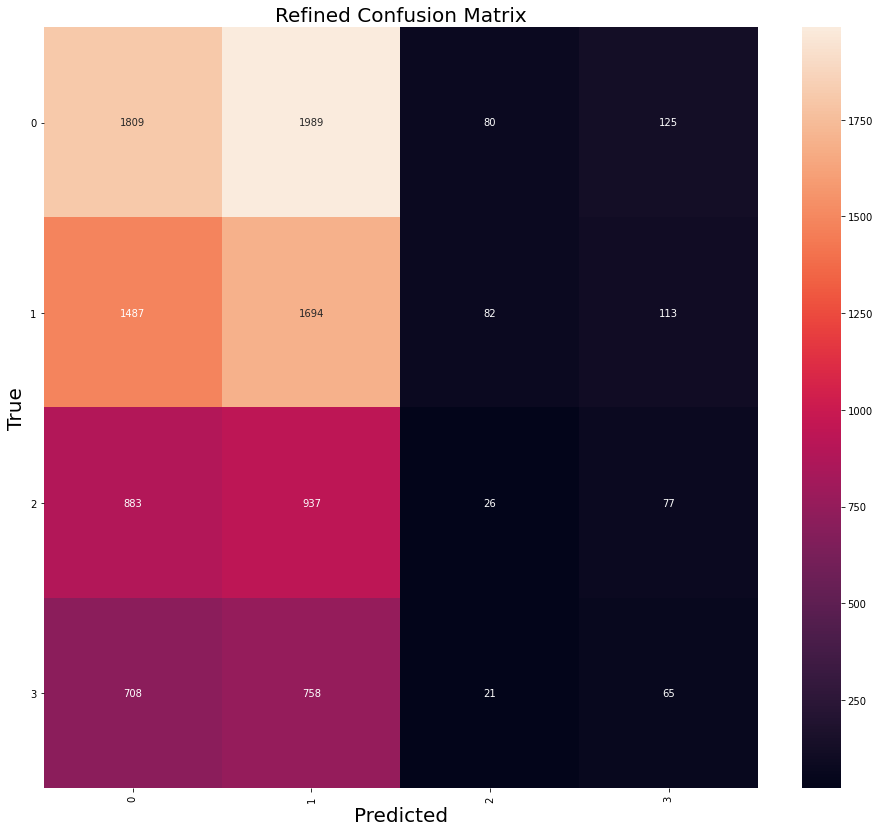

Random Forest mislabeled points out of a total 10854 points : 7260
                   Mid        North        South         West  accuracy  \
precision     0.370166     0.314987     0.124402     0.171053  0.331122   
recall        0.451911     0.501777     0.013521     0.041881  0.331122   
f1-score      0.406974     0.387023     0.024390     0.067288  0.331122   
support    4003.000000  3376.000000  1923.000000  1552.000000  0.331122   

              macro avg  weighted avg  
precision      0.245152      0.280990  
recall         0.252273      0.331122  
f1-score       0.221419      0.284415  
support    10854.000000  10854.000000  


In [16]:
rf_conf_condensed, rf_con_model = fit_rf(condensed_train, condensed_test, k=102, display_conf=True)

In [17]:
british_pred = rf_con_model.predict(british_df)



condensed_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

condensed_pred['pred_tally'] = 1

print(condensed_pred['pred_accent'].value_counts())


condensed__sum = condensed_pred.groupby('pred_accent').sum()
condensed__sum['pred_percent'] = condensed__sum['pred_tally'] / condensed__sum['pred_tally'].sum() * 100.00

condensed__sum.head(10)


North    336
West     194
Mid      189
South     13
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
Mid,189,25.819672
North,336,45.901639
South,13,1.775956
West,194,26.502732


In [18]:
consolidate_mas = {
    'North': 'East',
    'Mid': 'East',
    'South': 'East',
    'West': 'West',
}


condensed_train_two_regions, condensed_tes_two_regions = consolidate_regions(condensed_train, condensed_test, consolidate_mas)


condensed_train_two_regions.accent.value_counts()

East    27407
West     5821
Name: accent, dtype: int64

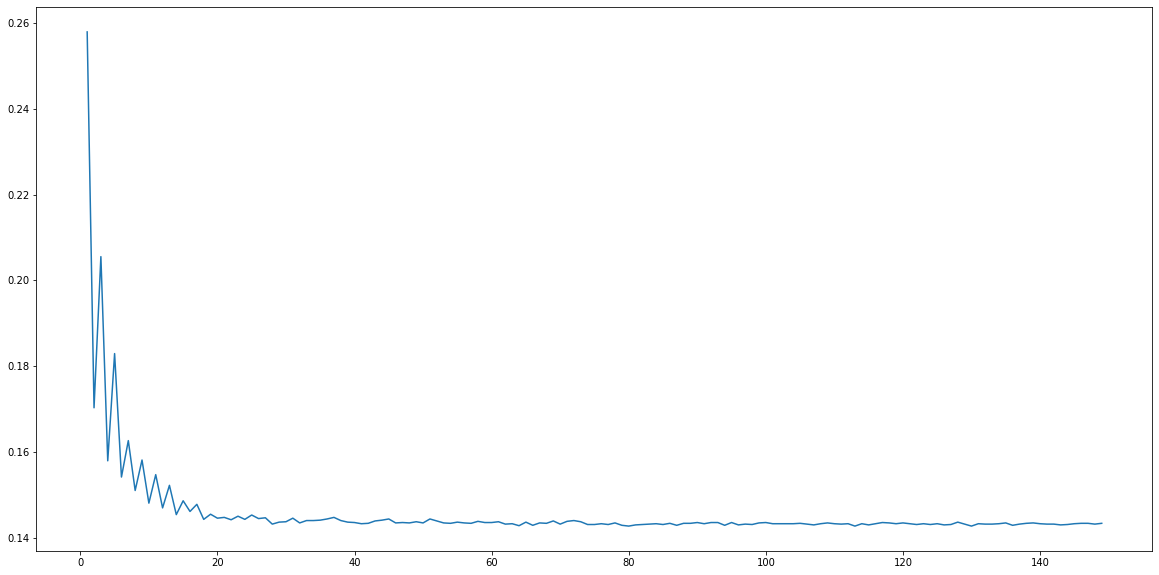

In [19]:
tree_counts, tree_count_score, opt_score_idx, opt_tree  = fit_rf(condensed_train_two_regions, condensed_tes_two_regions)

In [22]:
opt_tree

80

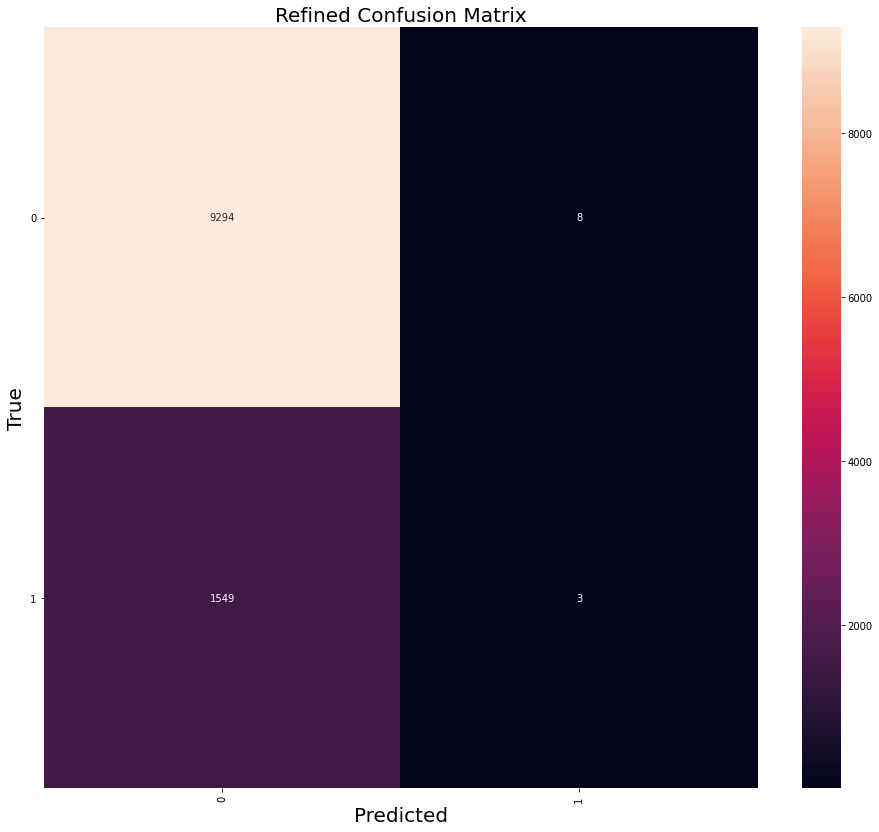

Random Forest mislabeled points out of a total 10854 points : 1557
                  East         West  accuracy     macro avg  weighted avg
precision     0.857143     0.272727  0.856551      0.564935      0.773578
recall        0.999140     0.001933  0.856551      0.500536      0.856551
f1-score      0.922710     0.003839  0.856551      0.463275      0.791322
support    9302.000000  1552.000000  0.856551  10854.000000  10854.000000


In [23]:
rf_conf_cm, rf_con_cm = fit_rf(condensed_train_two_regions, condensed_tes_two_regions, k=80, display_conf=True)

In [22]:
british_pred = rf_con_cm.predict(british_df)


cm_pred = pd.DataFrame(british_pred, columns = ['pred_accent'])

cm_pred['pred_tally'] = 1

print(cm_pred['pred_accent'].value_counts())


cm_pred__sum = cm_pred.groupby('pred_accent').sum()
cm_pred__sum['pred_percent'] = cm_pred__sum['pred_tally'] / cm_pred__sum['pred_tally'].sum() * 100.00

cm_pred__sum.head(10)

East    684
West     48
Name: pred_accent, dtype: int64


,pred_tally,pred_percent
pred_accent,,
East,684,93.442623
West,48,6.557377
